# CHSH Inequality

This tutorial shows how to run the CHSH inequality experiment in Braket on local simulator and a QPU.

For easy understanding, variables used here follow closely the reference: Scientific Background on the Nobel Prize in Physics 2022 [1]


# Background 

The CHSH (Clauser, Horne, Shimony and Holt) inequality is a generalization of Bell's inequality [3]. For a singlet state
$$|\psi ^{-}\rangle = \frac{1}{\sqrt{2}}\left(|+-\rangle + |-+\rangle \right )$$
the CHSH inequality is

$$
|E(a1,b1) + E(a1,b2) + E(a2,b1) - E(a2,b2)| \leq 2
$$
for measurement settings $a1,a2$ on the first particle and settings $b1,b2$ on the second particle. This reduces to Bell's original inequality if $a2=b1$.

Excerpts from the middle of page 5/17 of Reference [4] : 
"one can choose the vectors so that a1 ⋅ b1 = a1 ⋅ b2 = a2 ⋅ b1 = 1/√2, and thus〈S〉= 2√2, which is in clear violation of the CHSH version of the Bell inequality."

Here we are using angles synonmously with corresponding vectors.
Dot product of the unit vectors depeend just on cos(theta) where theta is the angle between the vectors. cos(theta)=cos(-theta).

Hence the correct measurement angle configuration to achive the above CSHS violation: 


## References 

[1] The Nobel Committee for Physics, Scientific Background on the Nobel Prize in Physics 2022, https://www.nobelprize.org/uploads/2022/10/advanced-physicsprize2022.pdf

[2] Greenberger, Daniel M., Michael A. Horne, Abner Shimony, and Anton Zeilinger (1990). Bell’s Theorem without Inequalities. American Journal of Physics 58, no. 12: 1131–43. https://doi.org/10.1119/1.16243. 

[3] John F. Clauser, Michael A. Horne, Abner Shimony, and Richard A. Holt. Proposed Experiment to Test Local Hidden-Variable Theories. Phys. Rev. Lett. 23, 880 – Published 13 October 1969; Erratum Phys. Rev. Lett. 24, 549 (1970) https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.23.880

[4]  Bell, J. S. On the Einstein Podolsky Rosen Paradox. Physics Physique Fizika 1, no. 3 (November 1, 1964): 195–200. https://doi.org/10.1103/PhysicsPhysiqueFizika.1.195. 

[5] John Preskill, Quantum Information and Computation, Chapter 4, Page 18, http://theory.caltech.edu/~preskill/ph229/notes/chap4_01.pdf

# Run on a local simulator

In [1]:
import numpy as np
from braket.devices import LocalSimulator
from braket.tracking import Tracker

from braket.experimental.algorithms.chsh_inequality import (
    create_chsh_inequality_circuits,
    run_chsh_inequality,
    get_chsh_results,
)

tracker = Tracker().start()  # to keep track of Braket costs

CHSH Inequality experiment consists of four circuits acting on two qubits each. The four circuits are grouped together in the `create_chsh_inequality_circuits` function below which takes as arguments the two qubits to act on and the two separate angles to rotate each qubits by. The default values for the angles:
$$a2 = 0$$
$$b1 = \pi/4$$
$$a1 = \pi/2$$
$$b2 = 3\pi/4$$

which gives maximum violation of the CHSH inequality. 

Explanation for the above specific measurement angles and the order:

Excerpts from the middle of page 5/17 of Reference Scientific Background on the Nobel Prize in Physics 2022 [1] : 
"one can choose the vectors so that a1 ⋅ b1 = a1 ⋅ b2 = a2 ⋅ b1 = 1/√2, and thus〈S〉= 2√2, which is in clear violation of the CHSH version of the Bell inequality."

Here we are using angles synonmously with corresponding vectors.
Dot product of the unit vectors depeend just on cos(theta) where theta is the angle between the vectors. Also relevant fact : cos(theta)=cos(-theta).

Hence the above mentioned measurement angle configuration is chosen. 

To remember the measurement angles one can use the following "thumbs rule":

  * right hand: thumb a1, index finger a2 
  * left hand: thumb b1, index finger b2
  * chris-cross both the hands crossing thumbs so that each thumb in the angle between the thumb and index finger of the other hand.


In [2]:
# Maximum violation of CHSH inequality for singlet states

circuits = create_chsh_inequality_circuits(a2= 0, b1= np.pi / 4, a1= np.pi / 2 , b2=3 * np.pi / 4 )

print("\ncircuit_a1b1: measurement setting for qubit0 at angle a1, qubit1 at angle b1\n",circuits[0])
print("\ncircuit_a1b2: measurement setting for qubit0 at angle a1, qubit1 at angle b2\n",circuits[1])
print("\ncircuit_a2b1: measurement setting for qubit0 at angle a2, qubit1 at angle b1\n",circuits[2])
print("\ncircuit_a2b2: measurement setting for qubit0 at angle a2, qubit1 at angle b2\n",circuits[3])


circuit_a1b1: measurement setting for qubit0 at angle a1, qubit1 at angle b1
 T  : |0|1|2|   3    |Result Types|
                                  
q0 : -X-H-C-Rx(1.57)-Probability--
          |          |            
q1 : -X---X-Rx(0.79)-Probability--

T  : |0|1|2|   3    |Result Types|

circuit_a1b2: measurement setting for qubit0 at angle a1, qubit1 at angle b2
 T  : |0|1|2|   3    |Result Types|
                                  
q0 : -X-H-C-Rx(1.57)-Probability--
          |          |            
q1 : -X---X-Rx(2.36)-Probability--

T  : |0|1|2|   3    |Result Types|

circuit_a2b1: measurement setting for qubit0 at angle a2, qubit1 at angle b1
 T  : |0|1|2|   3    |Result Types|
                                  
q0 : -X-H-C----------Probability--
          |          |            
q1 : -X---X-Rx(0.79)-Probability--

T  : |0|1|2|   3    |Result Types|

circuit_a2b2: measurement setting for qubit0 at angle a2, qubit1 at angle b2
 T  : |0|1|2|   3    |Result Types|
                

The circuits can be run on the Braket local simulator with:

In [3]:
local_tasks = run_chsh_inequality(circuits, LocalSimulator(), shots=0)

The results of the inequality experiment are called using the `get_chsh_results` function below.

In [4]:
chsh_value, results, E_a1b1, E_a1b2, E_a2b1, E_a2b2 = get_chsh_results(local_tasks, verbose=True)

P(a,b) = -0.7071067811865475, P(a,c) = -0.7071067811865472, P(d,b) = -0.7071067811865474, P(d,c) = 0.7071067811865472

CHSH inequality: 2.828427124746189 ≤ 2
CHSH inequality is violated!
Notice that the quantity may not be exactly as predicted by Quantum theory. This is may be due to finite shots or the effects of noise on the QPU.


Notice the CHSH value is very close to $2\sqrt{2}\approx 2.828$. 

Below, we plot the CHSH value for various values of the angles. 

In [5]:
local_simulator = LocalSimulator()
angles = np.linspace(0, 2 * np.pi, 100)

chsh_inequality_lhs_max = 0
chsh_inequality_lhs_max_theta = 0
chsh_values = []

for theta in angles:
    circuits = create_chsh_inequality_circuits(a2=0, b1=theta, a1=2 * theta, b2=3 * theta )
    local_tasks = run_chsh_inequality(circuits, local_simulator, shots=0)
    chsh_value, results, E_a1b1, E_a1b2, E_a2b1, E_a2b2 = get_chsh_results(local_tasks, verbose=False)
    if chsh_value > chsh_inequality_lhs_max:
        chsh_inequality_lhs_max = np.abs(chsh_value)
        chsh_inequality_lhs_max_theta = theta
    chsh_values.append(chsh_value)

print(
    "\nFor all the iterations:\n Max CHSH_inequality:",
    chsh_inequality_lhs_max,
    "Corresponding theta:",
    chsh_inequality_lhs_max_theta,
)


For all the iterations:
 Max CHSH_inequality: 2.8281587012240337 Corresponding theta: 2.3482611754105527


Plotting the CHSH Value against theta angle to determine which theta gives maximum violation.

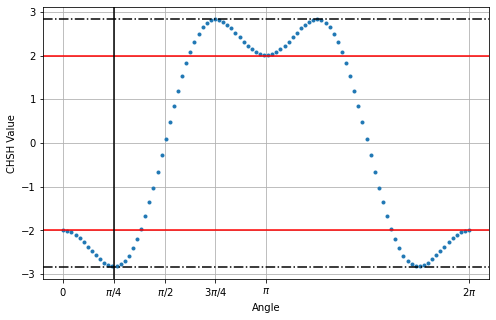

In [6]:
import matplotlib.pyplot as plt

%matplotlib inline

fig, ax = plt.subplots(figsize=(8, 5))
plt.plot(angles, chsh_values, ".", label="CHSH Value")

plt.grid(which="major", axis="both")
plt.axhline(y=2, color="r", linestyle="-")
plt.axhline(y=-2, color="r", linestyle="-")
plt.axvline(np.pi / 4, color="k", linestyle="-")
plt.axhline(y=np.sqrt(2) * 2, color="k", linestyle="-.")
plt.axhline(y=-np.sqrt(2) * 2, color="k", linestyle="-.")
plt.xticks([0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi, 2*np.pi], ["$0$", "$\pi/4$", "$\pi/2$", "$3\pi/4$", "$\pi$","$2\pi$"])
plt.xlabel("Angle")
plt.ylabel("CHSH Value");

From the plot, we see that the maximum violation is for $\theta = \pi/4$ as expected. The red line shows the classical bounds of $\text{CHSH} \leq 2$ and the dotted black line shows the quantum bound at $\text{CHSH} \leq 2\sqrt{2}$. 


Following sections how CHSH reduces to Bell's original inequality. 

In [7]:
# CHSH reduces to Bell's original inequality measurement configuration with a2=b1 and b2 middle of a1 and b1
# thumb rule: left hand index finger within the right hand thumb and index finger. 
# left hand thumb aligned with righ hand index finger

local_simulator = LocalSimulator()
angles = np.linspace(0, 2 * np.pi , 100)

bell_value_max = 0
bell_value_max_theta = 0
bell_value_max_E_a1b1=0
bell_value_max_E_a1b2=0
bell_value_max_E_a2b1=0
bell_value_max_E_a2b2=0
bell_values = []

for theta in angles:
    circuits = create_chsh_inequality_circuits(a2=0, b1=0, b2=theta, a1=2 * theta)
    local_tasks = run_chsh_inequality(circuits, local_simulator, shots=0)
    chsh_value, results, E_a1b1, E_a1b2, E_a2b1, E_a2b2 = get_chsh_results(local_tasks, verbose=False)
    #since d=b, E_a2b1 should be -1 and abs(E_a2b1)=1, subtracting this value from both sides of the CSHS inequality gives Bell inequality
    bell_value = np.abs(E_a1b1-E_a1b2)-E_a2b2
    if bell_value > bell_value_max:
        bell_value_max = np.abs(bell_value)
        bell_value_max_theta = theta
        bell_value_max_E_a1b1=E_a1b1
        bell_value_max_E_a1b2=E_a1b2
        bell_value_max_E_a2b1=E_a2b1
        bell_value_max_E_a2b2=E_a2b2
    bell_values.append(bell_value)

print(
    "\nFor all the iterations:\nMax Bell_inequality:",
    bell_value_max,
    "\nCorresponding theta:",
    bell_value_max_theta,
    "\nCorresponding E_a1b1, E_a1b2, E_a2b1, E_a2b2:",
    bell_value_max_E_a1b1,bell_value_max_E_a1b2,bell_value_max_E_a2b1,bell_value_max_E_a2b2
)


For all the iterations:
Max Bell_inequality: 1.4985175478267787 
Corresponding theta: 1.0154642920694281 
Corresponding E_a1b1, E_a1b2, E_a2b1, E_a2b2: 0.4440666126057739 -0.5272254676105024 -0.9999999999999998 -0.5272254676105024


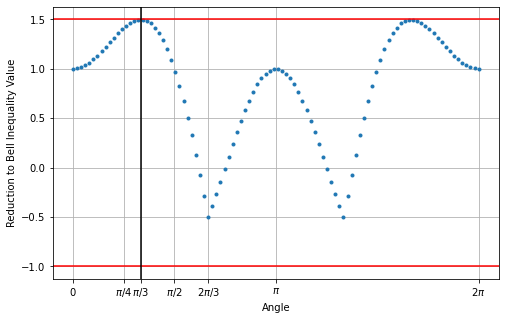

In [8]:
import matplotlib.pyplot as plt

%matplotlib inline

fig, ax = plt.subplots(figsize=(8, 5))
plt.plot(angles, bell_values, ".", label="Bell Inequality Value")

plt.grid(which="major", axis="both")
plt.axhline(y=1.5, color="r", linestyle="-")
plt.axhline(y=-1, color="r", linestyle="-")
plt.axvline(np.pi / 3, color="k", linestyle="-")
plt.xticks([0, np.pi/4,np.pi/3, np.pi/2, 2*np.pi/3, np.pi,2*np.pi], ["$0$", "$\pi/4$", "$\pi/3$","$\pi/2$", "$2\pi/3$", "$\pi$","$2\pi$"])
plt.xlabel("Angle")
plt.ylabel("Reduction to Bell Inequality Value");

# Run on a QPU

To run CHSH inequality on a QPU, we replace the LocalSimulator with an AwsDevice. 
To reduce the cost, we run the the experiment only for the correpsonding angles for $\theta = \pi/4$  which gave the maximum CHSH inequality value.(set as default angles in create_chsh_inequality_circuits function)

The cost to run this experiment is \$0.3 per task and \$0.00035 per shot on the Oxford Quantum Circuits Lucy device. Since we have four circuits of 1000 shots each, that totals \$2.60 USD.

In [9]:
# Uncomment the following to run on QPU
# from braket.aws import AwsDevice
# device = AwsDevice("arn:aws:braket:eu-west-2::device/qpu/oqc/Lucy")
# circuits = create_chsh_inequality_circuits()
# tasks = run_chsh_inequality(circuits, device, shots=1_000)
# chsh_value, results, E_a1b1, E_a1b2, E_a2b1, E_a2b2 = get_chsh_results(tasks)

We see that CHSH inequality is violated, so the device is demonstrating quantum behavior.

In [10]:
print(
    f"Estimated cost to run this example: {tracker.qpu_tasks_cost() + tracker.simulator_tasks_cost() :.2f} USD"
)

Estimated cost to run this example: 0.00 USD


Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).